### 1D Burger Equation NFTM Simulator using a CNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader

#### Load Training Data

* The following class builds training samples for training the NFTM.

* It extracts a spatial patch (neighbouring positions) at a fixed time $t$.

* The target value is the value at the center of the patch at the next time step $(t+1)$.

* INPUT: patch along the space at time $t$: $(u_{i-k, t},...,u_{i, t},...,u_{i+k, t})$ for a specific patch size $2k +1$.

* VISCOSITY $\nu$: a scalar.

* TARGET: $u_{i, t+1}$ (center's value in the next time step).

#### Extract local regions from field: create patches

* For each spatial position $i$, we want to extract the slide $[u_{i-r},...,u_i,...,u_{i+r}]$.

* $r$ is the patch radius (how many neighbours you consider from left and right side).

* We then pass this patch/region to the CNN controller to perform updates.

* Patch size: $2r +1$ (no. of points you take from spatial field).

* We create a 3D tensor `patches` storing the patch (neighbour points) for each spatial location in the field.

* Each `training sample` (patch): (input_patch, viscosity, target_value), where input_patch = neighbour points.

* `Batch size`: number of patches (training samples) running in parallel during each forward and backward pass of the NN.

### Training Data

* Input: `batch of input data patches` (shape = (batch_size, patch_size)) and a `batch of viscosities` (shape = (batch_size, 1)).

* Output: `batch of target values` at the input data patch center (shape = (batch_size, 1)).

In [72]:
class BurgersViscosityDataset(Dataset):
    def __init__(self, datasets, viscosities, patch_radius=1, pad_mode='replicate'):
        # datasets: list of tensors, each of shape (1, T, N)
        # viscosities: list of float scalars (one for each dataset)
        self.patches = []     # (num_samples, 2r+1)
        self.nu_vals = []     # (num_samples, 1)
        self.targets = []     # (num_samples, 1)
        patch_size = 2 * patch_radius + 1

        for data, nu in zip(datasets, viscosities):
            data = data.squeeze(0)  # (T, N): drop batch dim if present
            T, N = data.shape
            for t in range(T - 1):  # Last time step has no gt for (t+1)
                field = data[t]         # (N,)
                padded_field = torch.nn.functional.pad(field.unsqueeze(0), (patch_radius, patch_radius), mode=pad_mode).squeeze(0)  # (N + 2r,)
                # Extract all patches for this time step (N positions, including boundaries via padding):
                patches_t = padded_field.unfold(0, patch_size, 1)  # (N, patch_size)
                targets_t = data[t+1]  # (N,) next field
                # Viscosity: broadcast to all positions (N, 1)
                nu_col = torch.full((N, 1), float(nu), dtype=torch.float32)
                # Store
                self.patches.append(patches_t)
                self.nu_vals.append(nu_col)
                self.targets.append(targets_t.unsqueeze(1))
        # Concatenate all
        self.patches = torch.cat(self.patches, dim=0)   # (total_samples, patch_size)
        self.nu_vals = torch.cat(self.nu_vals, dim=0)   # (total_samples, 1)
        self.targets = torch.cat(self.targets, dim=0)   # (total_samples, 1)

    def __len__(self):
        return self.patches.shape[0]

    def __getitem__(self, idx):
        # Returns: spatial patch (patch_size,), viscosity (1,), target (1,)
        return self.patches[idx], self.nu_vals[idx], self.targets[idx]


In [82]:
current_dir = Path(os.getcwd()) # get current directory

# Files with datasets for 1D burger eq for different values of viscosity:
files_burger = {
    0.001: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.001.npz",
    0.01: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.01.npz",
    0.1: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.1.npz",
    0.5: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.5.npz"
}

datasets = [] # list to store tensors corresponding to each dataset: each tensor has shape (1, T, N)
viscosities = [] # list to store the different values of viscosity.

# Load and process all datasets:
for viscosity, path in files_burger.items():
    uu_tensor = np.load(str(path.resolve()))['u'] # shape (T, N)
    data_tensor = torch.tensor(uu_tensor, dtype=torch.float32).unsqueeze(0) # (1, T, N)
    datasets.append(data_tensor)
    viscosities.append(viscosity)


# Create combined dataset for training the NFTM:
patch_dataset = BurgersViscosityDataset(datasets, viscosities, patch_radius=1)


# The data set will consist of triples (patch, viscosity, target), starting at t = 0 (all positions), then t=1 (all positions),...
# indices 0,...,N-1 correspond to u(x_0,0), u(x_1, 0),...,u(x_{N-1}, 0)
# we will have 1024(N)*201(T) elements for each viscosity value.
# to get solutions u(x,t) for next viscosity value: 
patch, nu, target = patch_dataset[0] # corresponding to position x_0, t = 0 and nu = 0.001
# patch, nu, target = patch_dataset[205825] 
print("Patch:", patch)
print("Viscosity:", nu)
print("Target (next value):", target)


Patch: tensor([0.0031, 0.0031, 0.0092])
Viscosity: tensor([0.0010])
Target (next value): tensor([0.0030])


#### Continuous field as a spatial grid

* This field acts as the memory of the NFTM, storing the solution values at each spatial point.

* Make use of tensors to represent the spatial field.

* Create a 1D tensor of size N (no. of spatial points per time snapshot): will store the values of the solution $u$ at each spatial point for a specific time snapshot.

* Each 1D tensor (vector) represents the spatial field $u(x,t)$ at a given time $t$: $[x_0,..., x_{N-1}]$, where $N=$ no. of spatial values per snapshot.

* $f_t = [u(x_0, t), ..., u(x_{N-1},t)]$.

* To compute the field at the next time step $t+\Delta t$, we use the vector from the previous time step $t$ as input.

* Each dataset corresponding to a specific viscosity contains all solution trajectories (full temporal evolutions) for that viscosity, and thus has its own set of initial fields (initial conditions $u(x,t=0)$) associated with that viscosity.

* SAME INITIAL CONDITION FOR ALL DATASETS. VALUES OF $u(x, t= 0)$ are equal, regardless of the value of $\nu$.

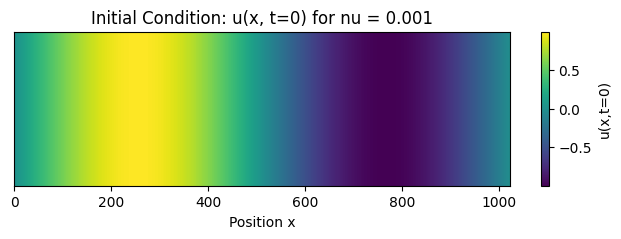

In [83]:
initial_field = datasets[0][0,0,:]  # initial field for t = 0  and nu = 0.001
# VISUALIZATION OF THE FIELD:
field_np = initial_field.numpy()

plt.figure(figsize=(8, 2))
plt.imshow(field_np[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='u(x,t=0)')
plt.xlabel('Position x')
plt.title(f'Initial Condition: u(x, t=0) for nu = 0.001')
plt.yticks([])
plt.show()


#### CNN controller

* Construct CNN that acts as the controller to process each patch.

* Typical architecture: input layer of patch size, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.

* The CNN processes patches independently across the field.


In [ ]:
# CNN controller definition:
# INPUTS: patch (spatial neighbourhood of the field) and nu (the viscosity).
# shape: (x, y, z)
# x = batch_size (number of patches you process at once).
# y = no. of output feature maps produced.
# z = output sequence length.
class CNNController(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
        # Two input channels (in_channels = 2): field patch and viscosity
        # First convolutional layer:
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=patch_size, padding=0) # output shape: (batch_size, 16, 1).
        # ReLU activation function -> introduces non-linearity
        self.activation1 = nn.ReLU()
        # Pooling layer -> reduce to single value:
        self.pool1 = nn.AdaptiveMaxPool1d(1)
        # Second convolutional layer: kernel_size = 1 since this layer only considers the current point and not neighbouring points.
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=1)
        # ReLU activation function -> introduces non-linearity
        self.activation2 = nn.ReLU()
        # Connected layer:
        self.final_fc = nn.Sequential(
            nn.Flatten(start_dim=1), # flattens feature map to size (batch_size, 32)
            nn.Linear(32, 1) # maps all 32 features into a single output
            # the predicted value at the next time step at the center of the patch.
        )

    def forward(self, patch, nu):
        # patch: (batch_size, patch_size)
        # nu: (batch_size, 1)
        # nu values are repeated to match the patch size, so each location's patch and viscosity become 2 parallel vectors.
        nu_channel = nu.repeat(1, self.patch_size)
        x = torch.stack([patch, nu_channel], dim=1)  # (batch_size, 2, patch_size)
        # First convolutional layer: takes 2 input channels and outputs 16 feature maps.
        x = self.conv1(x)  # (batch_size, 16, 1)
        # ReLU activation function:
        x = self.activation1(x)
        # Reduce each filter's output to a single value using pooling layer:
        x = self.pool1(x)  # (batch_size, 16, 1)
        # Second convolutional layer: takes 16 input channels and outputs 32 output channels.
        x = self.conv2(x)  # (batch_size, 32, 1)
        # ReLU activation function:
        x = self.activation2(x)
        x = x.view(x.shape[0], -1)
        x = self.final_fc(x)  # (batch_size, 1)
        return x
    

    
# Create CNN controller for our NFTM:
cnn_controller = CNNController(patch_size = 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_controller.to(device)

CNNController(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,))
  (activation1): ReLU()
  (pool1): AdaptiveMaxPool1d(output_size=1)
  (conv2): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (activation2): ReLU()
  (final_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)

#### Read/Write head

* The controller reads patches, computes local updates, and writes these updates back into the corresponding local regions of the field.

* Reading: extract patches (local neighbourhoods) centered at each spatial position. These patches have shape `(batch_size, N, patch_size)`.

* Need to **reshape** patches to `(batch_size * N, 1, patch_size)`, to go as **input** into the CNN controller. This enables the CNN to process all patches in parallel as separate inputs in a batch.

* We treat each patch (local neighbours) as a separate 1D sample with 1 channel + length equal to patch_size.

* CNN **outputs** a **scalar value** per patch, with shape: `(batch_size * N, 1, 1)`.

* Need to **reshape** back to the field shape: `(batch_size,  N)`.

* Writing: updating the field.


#### Loss Function

* A common choice for the cost function is the MSE: $$L_{MNE} = \frac{1}{N} \sum_{i = 1}^{N} \sum_{t = 1}^{T} (u_{i,t} - \hat u_{i,t})^2$$

* N = no. spatial points at each time snapshot.

* T = no. of time snapshots where solution is considered.

* $\hat u_{i,t}$ = NFTM's predicted velocity at spatial point $i$ and time $t$.

* $u_{i,t}$ = truth velocity at spatial point $i$ and time $t$.

* The error between predicted values and truth solutions from your training data at different time steps.

In [85]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

* We backpropagate the loss and update the CNN controller's weights using an optimizer.

    * Clear the gradients before backpropagation: `optimizer.zero_grad()`.

    * Compute gradients of the loss with respect to model parameters (backpropagation): `loss.backward()`.

    * Update the model parameters using the computed gradients: `optimizer.step()`.

* We can use the Adam optimizer among others.

In [86]:
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-3) # OPTIMIZER

#### Training Loop: 10 epochs

In [69]:
train_loader = DataLoader(patch_dataset, batch_size=64, shuffle=True)

num_epochs = 10  # adjust as needed
epoch_losses = []  # list to store average loss per epoch
# fields_history = []  # Optionally store predictions for heatmap
cnn_controller.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for patch, nu, target in train_loader:
        patch, nu, target = patch.to(device), nu.to(device), target.to(device)
        optimizer.zero_grad() # clear the gradients
        predicted = cnn_controller(patch, nu)  # (batch_size, 1)
        loss = mse_loss(predicted, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * patch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.6f}")

Epoch 1/10: Loss=0.000554
Epoch 2/10: Loss=0.000021
Epoch 3/10: Loss=0.000020
Epoch 4/10: Loss=0.000018
Epoch 5/10: Loss=0.000016
Epoch 6/10: Loss=0.000014
Epoch 7/10: Loss=0.000012
Epoch 8/10: Loss=0.000011
Epoch 9/10: Loss=0.000011
Epoch 10/10: Loss=0.000010


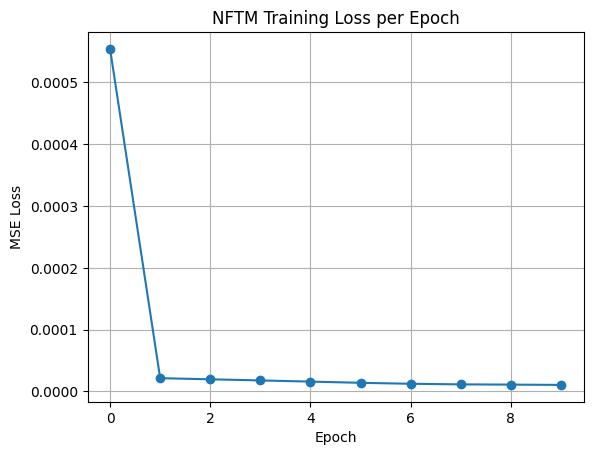

In [ ]:
# Loss Evolution Plot
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()

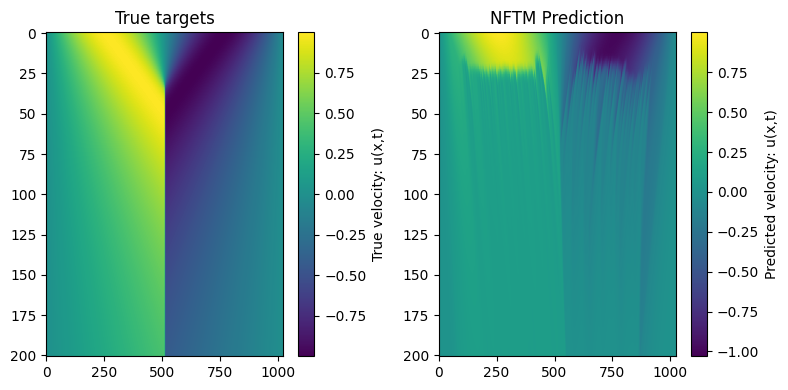

In [ ]:
# Heatmap to compare the true and predicted solutions.
# Choose a viscosity and corresponding data set
data_tensor = datasets[0]  # data set corresponding to nu = 0.001
nu_fixed = viscosities[0]

with torch.no_grad():
    u_pred = [data_tensor[0,0,:].to(device)]  # initial field
    for t in range(data_tensor.shape[1] - 1):
        current_field = u_pred[-1]
        # Pad and extract patches
        padded = torch.nn.functional.pad(current_field.unsqueeze(0), (1, 1), mode='replicate').squeeze(0)
        patches = padded.unfold(0, 3, 1)
        nu_vals = torch.full((patches.shape[0], 1), float(nu_fixed), device=device)
        next_u = cnn_controller(patches, nu_vals).squeeze(1)
        u_pred.append(next_u) # update continuous field with the patch corresponding to next time step.
    u_pred = torch.stack(u_pred)  # Shape: (T, N)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(data_tensor[0].cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='True values u(x,t) for viscosity = 0.001')
plt.title('True targets')

plt.subplot(1, 2, 2)
plt.imshow(u_pred.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted values u(x,t) for viscosity = 0.001')
plt.title('NFTM Prediction')
plt.tight_layout()
plt.show()



#### Training Loop: 20 epochs

In [87]:
train_loader = DataLoader(patch_dataset, batch_size=64, shuffle=True)

num_epochs = 20  # adjust as needed
epoch_losses = []  # list to store average loss per epoch
# fields_history = []  # Optionally store predictions for heatmap
cnn_controller.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for patch, nu, target in train_loader:
        patch, nu, target = patch.to(device), nu.to(device), target.to(device)
        optimizer.zero_grad() # clear the gradients
        predicted = cnn_controller(patch, nu)  # (batch_size, 1)
        loss = mse_loss(predicted, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * patch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.6f}")

Epoch 1/20: Loss=0.000674
Epoch 2/20: Loss=0.000020
Epoch 3/20: Loss=0.000019
Epoch 4/20: Loss=0.000018
Epoch 5/20: Loss=0.000016
Epoch 6/20: Loss=0.000014
Epoch 7/20: Loss=0.000013
Epoch 8/20: Loss=0.000012
Epoch 9/20: Loss=0.000011
Epoch 10/20: Loss=0.000011
Epoch 11/20: Loss=0.000010
Epoch 12/20: Loss=0.000010
Epoch 13/20: Loss=0.000009
Epoch 14/20: Loss=0.000009
Epoch 15/20: Loss=0.000009
Epoch 16/20: Loss=0.000009
Epoch 17/20: Loss=0.000009
Epoch 18/20: Loss=0.000008
Epoch 19/20: Loss=0.000008
Epoch 20/20: Loss=0.000008


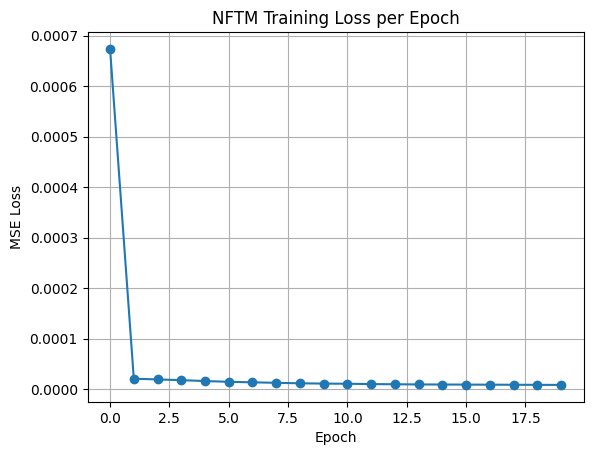

In [88]:
# Loss Evolution Plot
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()

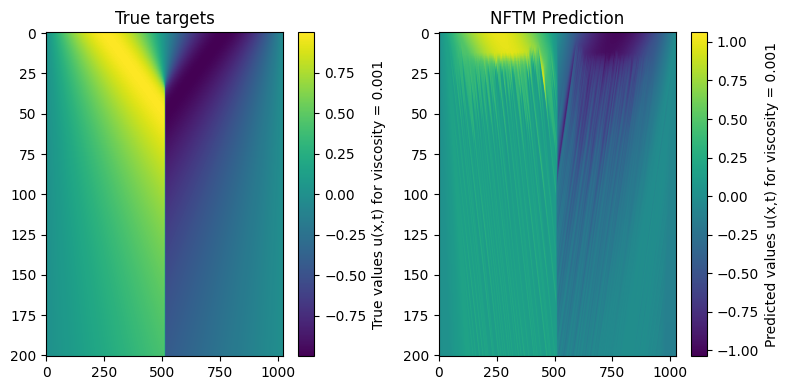

In [89]:
# Heatmap to compare the true and predicted solutions.
# Choose a viscosity and corresponding data set
data_tensor = datasets[0]  # data set corresponding to nu = 0.001
nu_fixed = viscosities[0]

with torch.no_grad():
    u_pred = [data_tensor[0,0,:].to(device)]  # initial field
    for t in range(data_tensor.shape[1] - 1):
        current_field = u_pred[-1]
        # Pad and extract patches
        padded = torch.nn.functional.pad(current_field.unsqueeze(0), (1, 1), mode='replicate').squeeze(0)
        patches = padded.unfold(0, 3, 1)
        nu_vals = torch.full((patches.shape[0], 1), float(nu_fixed), device=device)
        next_u = cnn_controller(patches, nu_vals).squeeze(1)
        u_pred.append(next_u) # update continuous field with the patch corresponding to next time step.
    u_pred = torch.stack(u_pred)  # Shape: (T, N)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(data_tensor[0].cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='True values u(x,t) for viscosity = 0.001')
plt.title('True targets')

plt.subplot(1, 2, 2)
plt.imshow(u_pred.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted values u(x,t) for viscosity = 0.001')
plt.title('NFTM Prediction')
plt.tight_layout()
plt.show()

### Error heatmap

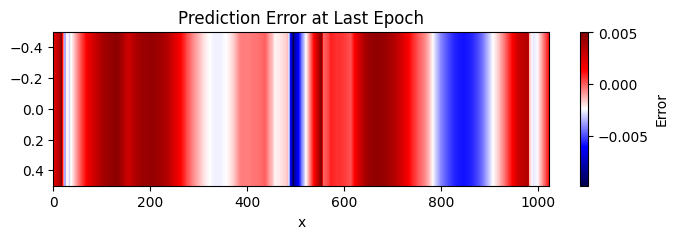

In [ ]:
# Error at each grid point and time
error = u_pred.cpu().numpy() - data_tensor[0].cpu().numpy()  # shape (T, N)
abs_error = np.abs(error)
plt.figure(figsize=(8, 3))
plt.imshow(abs_error, aspect='auto', cmap='hot')
plt.colorbar(label='|Prediction - True|')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title('NFTM Error Heatmap')
plt.tight_layout()
plt.show()


Summary of the Architecture:

* Input: 1D spatial field representing $u(x,t)$.

* Patch extraction: Sliding local neighborhoods of radius $r$.

* Controller: CNN processing each local patch.

* Update: Local field value updates returned by CNN.

* Iteration: Time-stepping loop applying CNN update repeatedly.

* Output: Predicted evolution of $u(x,t)$ over time.

This setup lets you build an end-to-end differentiable NFTM that learns local update rules via convolutional kernels, naturally capturing the physics of the 1D Burgers equation with your training data.